In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data.csv"))
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
df_typo = df["typology"] # needed for stratification below
df = pd.get_dummies(df, columns=["language", "canton", "typology"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df_typo)
X_train = df_train.drop(columns=["name", "po_value"]).values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns=["name", "po_value"]).values
y_test = df_test["po_value"].values

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

X_train.shape = (1756, 88)
y_train.shape = (1756,)
X_test.shape = (440, 88)
y_test.shape = (440,)


In [4]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
print("Dummy MAE = {:.3f}".format(mean_absolute_error(y_test, dummy.predict(X_test))))

Dummy MAE = 0.315


In [5]:
ridge = Pipeline([
    ('stdscaler', StandardScaler()),
    ('ridge', Ridge())
])
# print(ridge.get_params())
ridge.fit(X_train, y_train)
ridge_test_pred = ridge.predict(X_test)
print("Ridge MAE = {:.3f}".format(mean_absolute_error(y_test, ridge_test_pred)))
print("Ridge R^2 = {:.3f}".format(ridge.score(X_test, y_test)))

Ridge MAE = 0.169
Ridge R^2 = 0.700


In [6]:
parameters = { "ridge__alpha": np.logspace(-4, 4, num = 33) }
gcv = GridSearchCV(ridge, parameters, scoring = "neg_mean_absolute_error", cv = 5, iid = False, n_jobs=12)
gcv.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best alpha = {:.2f}".format(gcv.best_params_["ridge__alpha"]))
print("Best MAE = {:.3f}".format(-gcv.best_score_))

Grid search / cross-validation:
Best alpha = 3.16
Best MAE = 0.177


In [7]:
gcv_test_pred = gcv.predict(X_test)
print("On test data:")
print("Tuned Ridge MAE = {:.3f}".format(mean_absolute_error(y_test, gcv_test_pred)))
print("Tuned Ridge R^2 = {:.3f}".format(r2_score(y_test, gcv_test_pred)))

On test data:
Tuned Ridge MAE = 0.169
Tuned Ridge R^2 = 0.700


In [8]:
def validationcurve_plot(name, param_range, train_scores, test_scores):
    """Plots a validation curve and marks the best test score."""
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    sns.set_style('whitegrid')
    ax = sns.lineplot(param_range, train_scores_mean, label="train")
    ax.set_xscale('log')
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
    ax = sns.lineplot(param_range, test_scores_mean, label="test")
    ax.set_xscale('log')
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
    plt.title("Validation curve for " + name)

    best_idx = test_scores_mean.argmax()
    plt.scatter(param_range[best_idx], test_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    plt.legend()
    plt.show()

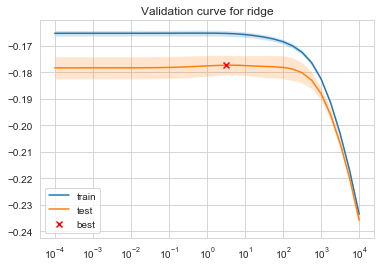

In [9]:
param_range = np.logspace(-4, 4, num = 33)
train_scores, test_scores = validation_curve(ridge, X_train, y_train, param_name="ridge__alpha",
                                             scoring = "neg_mean_absolute_error", param_range=param_range,
                                             cv=5, n_jobs=12)
validationcurve_plot("ridge", param_range, train_scores, test_scores)

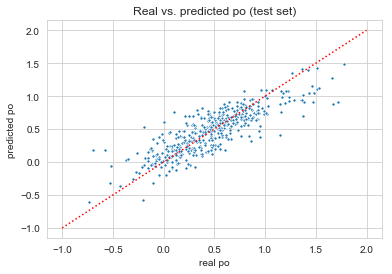

In [10]:
sns.scatterplot(y_test, ridge_test_pred, s=10)
plt.xlabel("real po")
plt.ylabel("predicted po")
plt.title("Real vs. predicted po (test set)")
plt.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()